In [1]:
# =========================
# CELL 0: COMMON SETUP
# =========================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

# Scaling
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Create sequences
#Use the previous 60 days of stock prices to predict the price of the next day



X_train, y_train = [], []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0]) #Index: 0 → 59   → used as input
    y_train.append(training_set_scaled[i, 0]) #Index: 60       → predicted value

X_train = np.array(X_train)
y_train = np.array(y_train)

# Dataset class
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [2]:
# =========================
# CELL 1: SIMPLE RNN
# =========================
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = RNNModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 100
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    
    print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.020724
Epoch 1, Loss: 0.001714
Epoch 2, Loss: 0.000421
Epoch 3, Loss: 0.000862
Epoch 4, Loss: 0.000438
Epoch 5, Loss: 0.000776
Epoch 6, Loss: 0.000692
Epoch 7, Loss: 0.000618
Epoch 8, Loss: 0.000666
Epoch 9, Loss: 0.000151
Epoch 10, Loss: 0.000488
Epoch 11, Loss: 0.002104
Epoch 12, Loss: 0.000439
Epoch 13, Loss: 0.000926
Epoch 14, Loss: 0.000227
Epoch 15, Loss: 0.000327
Epoch 16, Loss: 0.000441
Epoch 17, Loss: 0.000138
Epoch 18, Loss: 0.000649
Epoch 19, Loss: 0.000352
Epoch 20, Loss: 0.001180
Epoch 21, Loss: 0.000150
Epoch 22, Loss: 0.000259
Epoch 23, Loss: 0.000332
Epoch 24, Loss: 0.000272
Epoch 25, Loss: 0.000117
Epoch 26, Loss: 0.000368
Epoch 27, Loss: 0.000292
Epoch 28, Loss: 0.000074
Epoch 29, Loss: 0.000184
Epoch 30, Loss: 0.000391
Epoch 31, Loss: 0.000448
Epoch 32, Loss: 0.000669
Epoch 33, Loss: 0.001675
Epoch 34, Loss: 0.000174
Epoch 35, Loss: 0.000186
Epoch 36, Loss: 0.000300
Epoch 37, Loss: 0.000192
Epoch 38, Loss: 0.000315
Epoch 39, Loss: 0.000238
Epoch 40, 

In [3]:
# =========================
# EVALUATION: TEST SET
# =========================

# Load test data
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Combine train + test for sequence creation
dataset_total = pd.concat(
    (dataset_train['Open'], dataset_test['Open']), axis=0
).values.reshape(-1, 1)

# Scale
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:]
inputs = sc.transform(inputs)

# Create test sequences
X_test = []
for i in range(60, 60 + len(dataset_test)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Prediction
model.eval()
with torch.no_grad():
    predicted_stock_price = model(X_test).cpu().numpy()

# Inverse scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [6]:
import pandas as pd

# After predicting stock prices:

# Create a DataFrame with both real and predicted prices
df_comparison = pd.DataFrame({'Real Stock Price': real_stock_price.reshape(len(real_stock_price)),
                             'Predicted Stock Price': predicted_stock_price.reshape(len(predicted_stock_price))})

# Display the DataFrame
print(df_comparison)

    Real Stock Price  Predicted Stock Price
0             778.81             779.017822
1             788.36             775.548462
2             786.08             784.648743
3             795.26             782.899109
4             806.40             790.946350
5             807.86             801.604004
6             805.00             803.139954
7             807.14             800.191284
8             807.48             801.853699
9             807.08             802.692322
10            805.81             802.466797
11            805.12             801.179382
12            806.91             800.463318
13            807.25             802.221130
14            822.30             802.630920
15            829.62             816.560425
16            837.81             823.784424
17            834.71             831.129272
18            814.66             828.111572
19            796.86             809.242371


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)

print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")


RMSE : 9.732
MAE  : 8.114
R²   : 0.564


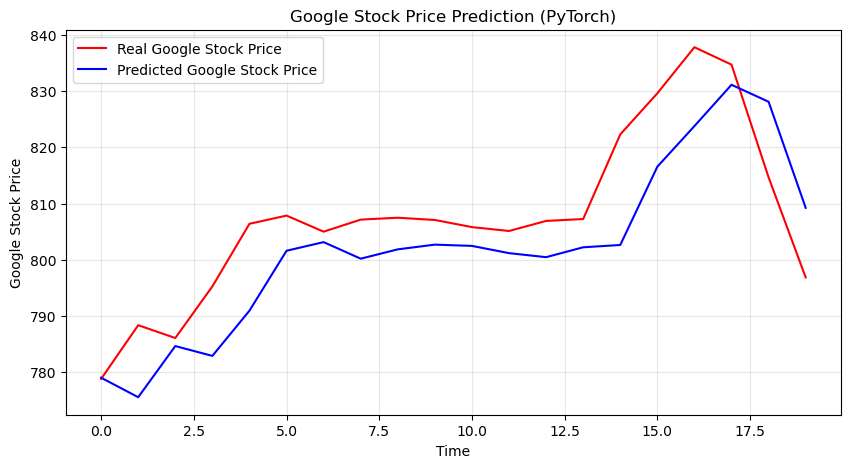

In [5]:
# =========================
# VISUALIZATION
# =========================
plt.figure(figsize=(10,5))
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction (PyTorch)')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
